In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle as pkl
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50V2, DenseNet121, VGG19, EfficientNetB7, InceptionV3, MobileNetV3Large
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU, TimeDistributed
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
import re

In [31]:
# Load model
model = load_model('models\custom_CNN_model.h5')

In [32]:
# dataset dir
dataset_dir = "dataset_preprocessed_4_final"

# Create the test set
test_set = []

for class_dir in os.listdir(dataset_dir):
    class_dir_path = os.path.join(dataset_dir, class_dir)
    for i, img in enumerate(os.listdir(class_dir_path)):
        if i < 500:
            img_path = os.path.join(class_dir_path, img)
            test_set.append((img_path, class_dir))

# shuffle the test set
np.random.shuffle(test_set)

test_df = pd.DataFrame(test_set, columns=['image', 'label'])

test_df

,image,label
0,dataset_preprocessed_4_final\No Dementia\1476.jpg,No Dementia
1,dataset_preprocessed_4_final\No Dementia\1238.jpg,No Dementia
2,dataset_preprocessed_4_final\Dementia\324.jpg,Dementia
3,dataset_preprocessed_4_final\Dementia\3528.jpg,Dementia
4,dataset_preprocessed_4_final\No Dementia\1251.jpg,No Dementia
...,...,...
995,dataset_preprocessed_4_final\No Dementia\1258.jpg,No Dementia
996,dataset_preprocessed_4_final\Dementia\167.jpg,Dementia
997,dataset_preprocessed_4_final\Dementia\335.jpg,Dementia
998,dataset_preprocessed_4_final\No Dementia\1256.jpg,No Dementia


In [33]:
# Create test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1000 validated image filenames belonging to 2 classes.


In [34]:
# evaluate the model
model.evaluate(test_gen)

32/32 [==============================] - 2s 37ms/step - loss: 0.3728 - accuracy: 0.9040


[0.3727515935897827, 0.9039999842643738]

In [35]:
# predict the test set
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

# get the true labels
y_true = test_gen.classes

# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

print(cm)

[[474  26]
 [ 70 430]]


In [36]:
# Get all metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

results = {
    'f1': f1,
    'precision': precision,
    'recall': recall,
    'accuracy': accuracy,
    'specificity': specificity,
    'sensitivity': sensitivity
}
results_df = pd.DataFrame(results, index=[0])
results_df

,f1,precision,recall,accuracy,specificity,sensitivity
0,0.899582,0.942982,0.86,0.904,0.948,0.86


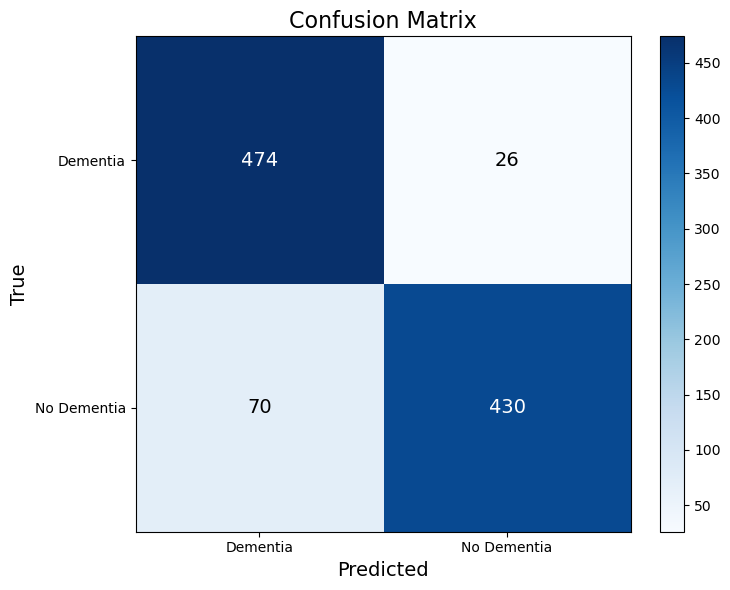

In [37]:
from matplotlib.colors import Normalize

# Class labels (you can customize these)
class_labels = ['Dementia', 'No Dementia']

# Normalize color map based on the confusion matrix values
norm = Normalize(vmin=cm.min(), vmax=cm.max())

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('Blues')

# Create a heatmap using the color map
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontsize=14,
                color="white" if norm(cm[i, j]) > 0.5 else "black")

# Set the colors based on the normalized value
colors = cmap(norm(cm.ravel())).reshape(cm.shape + (4,))
ax.imshow(colors, interpolation='nearest', cmap=cmap)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)

# Set tick marks for grid
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Labels and title
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True', fontsize=14)
plt.xlabel('Predicted', fontsize=14)

plt.tight_layout()
plt.show()